In [ ]:
#IMPORTS
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import torchvision.models as models
from torch.autograd import Variable
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow


### Question 1: Saliency map using simple gradient method
Given a Pretrained VGG16 model, find out the mean of the maximum pixel values across each channel of the saliency map generated using the "Simple Gradient" method.

which of the following values are true?


1.   Mean - 0.0955
2.   Mean - 0.1121
3.   Mean - 0.1258
4.   Mean - 0.1248

Answer (2)

In [ ]:
#Custom function to display the image using matplotlib
def imshow(img, title):
  plt.figure(figsize = (4, 4))
  plt.axis("off")
  plt.imshow(img)
  plt.title(title)
  plt.show()

#custom function to preprocess the image
def preprocess_image(img, resize_im=True):
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(img) != Image.Image:
        try:
            img = Image.fromarray(img)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        img = img.resize((224, 224), Image.ANTIALIAS)

    im_arr = np.float32(img)
    im_arr = im_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_arr):
        im_arr[channel] /= 255
        im_arr[channel] -= mean[channel]
        im_arr[channel] /= std[channel]
    # Convert to float tensor
    im_float = torch.from_numpy(im_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_float.unsqueeze_(0)
    # Convert to Pytorch variable
    im_var = Variable(im_float, requires_grad=True)
    return im_var


In [ ]:
#importing the imagenet-pretrained vgg16 model
model = torchvision.models.vgg16(pretrained=True)


#setting the grad option to false because we do not have to train the model
for param in model.parameters():
    param.requires_grad = False

# reading the input image
img = Image.open('car.png').convert('RGB')

#calling the above defined preprocessing function
X = preprocess_image(img)

### YOUR CODE STARTS HERE ###

#we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
# find more info regarding the same here: https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html
X.requires_grad_()

#forward pass through the model to get the logit scores.
logits = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
logits_max_index = logits.argmax()
logits_max = logits[0, logits_max_index]


#backward function on logits_max performs the backward pass in the computation graph and calculates the gradient of
#score_max with respect to nodes in the computation graph

logits_max.backward()


#Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
#R, G and B. Now, take the max pixel value accross each channel and take the mean of these values.

absolute_value = torch.squeeze(X.grad.data.abs())

#iterating through every channel to obtain the max of each channel
max_values = []
for i in range(absolute_value.shape[0]):
  max_values.append(absolute_value[i].max())

#calculating the mean of the values obtained using the above loop
print(sum(max_values)/len(max_values))

### YOUR CODE ENDS HERE ###

<ipython-input-2-b7e9a614dc50>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


tensor(0.1094)


### Question 2: Occlusion Sensitivity - most sensitive location
Given a Pretrained VGG16 model and a test image, follow the following steps to calculate the answer:

Step 1. Load the given image and pre-process it. \\
Step 2. Calculate the max predicted label with the help of class probabilities. (required for answering question 3)\\
Step 3. Conduct the occlusion sensitivity experiments with the given mask (square in shape) size and stride. \\
Step 4. Find the position of mask which causes the highest drop in prediction probability. \\
Step 5. Add the X and Y coordinates of the top left and bottom right corners of that position and calculate the mean of it. \\

What is the range of the value obtained in Step 5?
1. 100 - 120
2. 200 - 210
3. 460 - 470
4. 390 - 400

Answer (4)



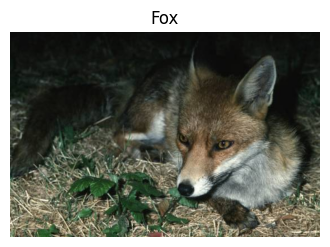

<ipython-input-2-b7e9a614dc50>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


In [ ]:
#opening the image
image = Image.open('fox.jpg').convert('RGB')

#displaying it
imshow(image, 'Fox')
prep_img = preprocess_image(image)

In [ ]:
#running inference on the images without occlusion
model = models.vgg16(pretrained=True)

#running the model in the eval mode
model.eval()

### YOUR CODE STARTS HERE ###

#vgg16 pretrained model
#forward pass the image through the model to get outputs
outputs = model(prep_img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label and the maximum probability, hint: use torch.max function
#store the maximum probability in a variable called "prob_no_occ" and maximum predicted label in a variable called pred_old
prob_no_occ, pred_old = torch.max(outputs.data, 1)

#printing the prediction
print(pred_old)

### YOUR ENDS HERE ###

tensor([277])


In [ ]:
#custom function to conduct occlusion experiments
def occlusion(model, image, label, occ_size, occ_stride, occ_pixel = 0.5):

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]

    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))

    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))

    flag_prob = 1
    h_min_start = 0
    w_min_start = 0
    h_min_end = 0
    w_min_end = 0
    #iterate all the pixels in each column
    for h in range(0, height):
        # print(h)
        for w in range(0, width):

            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)

            if (w_end) >= width or (h_end) >= height:
                continue

            ### YOUR CODE STARTS HERE ###

            #clone the image and detach it
            input_image = image.clone().detach()

            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel

            #run inference on modified image
            output = model(input_image)

            #pass the outputs through softmax
            output = nn.functional.softmax(output, dim=1)

            #find the probability of the image belonging to the input label
            #Note: we want to see how the probability of the image belonging to the particular class
            #changes through the experiment
            prob = output.tolist()[0][label]

            #setting the heatmap location to probability value
            heatmap[h, w] = prob

            #tracking the most sensitive locations, i.e the area which has the most amount of reduction in the
            #prediction probability. Write an if statement to track the lowest probability and its corresponding location
            #in the form of top left coordinate and bottom right coordinate i.e (h_min_start, w_min_start) and (h_min_end, w_min_end)
            if float(prob) < flag_prob:
              h_min_start = h_start
              w_min_start = w_start
              h_min_end = h_end
              w_min_end = w_end
              flag_prob = float(prob)

            ### YOUR CODE ENDS HERE ###



    return heatmap, h_min_start, w_min_start, h_min_end, w_min_end, flag_prob

In [ ]:
### YOUR CODE STARTS HERE ###

#calling the occlusion function
heatmap, h_min_start, w_min_start, h_min_end, w_min_end, flag_prob = occlusion(model, prep_img, pred_old[0].item(), 80, 25)

#summing the coordinates of the top left corner and bottom right corner and taking a mean of it
mean_coord = h_min_start + h_min_end + w_min_start + w_min_end / 4
print(mean_coord)

### YOUR CODE ENDS HERE ###


393.75


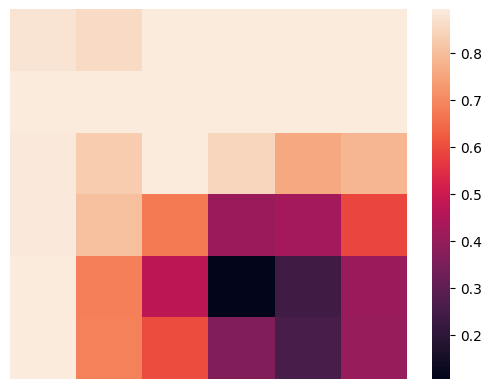

In [ ]:
#visualising the heatmap
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()
figure.savefig('svm_conf.png', dpi=400)

### Question 3: Occlusion Sensitivity - change in prediction with occlusion
With the coordinates of the most sensitive positions of the mask obtained in the above question, overlay a mask (of black pixels) on the original input image and find the new predicted max label when passed through the pre-trained VGG16 model.

What is the value of new predicted max label of the image - old predicted max label of the image?
1. 55
2. 124
3. 85
4. 68

Answer (3)



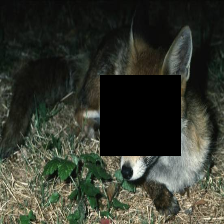

In [ ]:
#read the image
img1 = cv2.imread('fox.jpg')

### YOUR CODE STARTS HERE ###

#resize the image to (224, 224)
img1 = cv2.resize(img1, (224, 224))

#make a square mask (using black pixels) on the input image with the above obtained coordinates using the cv2.rectangle function
#and name the final resultant image as out
out = cv2.rectangle(img1, (h_min_start, w_min_start), (h_min_end, w_min_end), (0, 0, 0), -1)

### YOUR CODE ENDS HERE ###

#visualising the image after masking
cv2_imshow(out)


In [ ]:
#running inference on the images with occlusion
#preprocessing the occluded image
prep_img_new = preprocess_image(out)

#defining the pretrained model and setting it to the eval mode
model = models.vgg16(pretrained=True)
model.eval()

#passing the input through the vgg16 pretrained model
outputs = model(prep_img_new)

#passing the outputs through softmax to obtain the probability distribution
outputs = nn.functional.softmax(outputs, dim = 1)

#calculating the maximum predicted label
prob_no_occ, pred_new = torch.max(outputs.data, 1)

#check the new prediction
print(pred_new)

#calculating new prediction - old prediction
print(int(pred_new) - int(pred_old))


<ipython-input-2-b7e9a614dc50>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


tensor([362])
85
